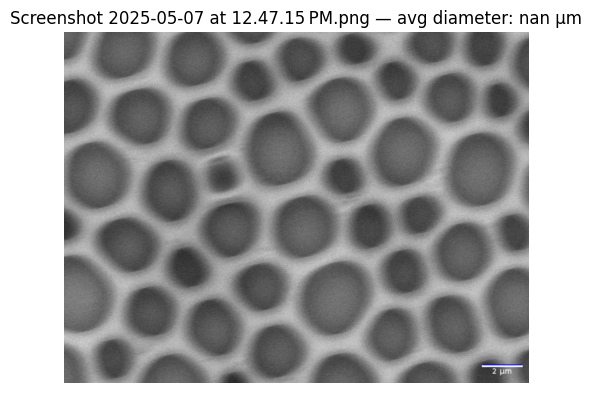

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_scale_bar(image, known_length_um=2.0):
    h, w = image.shape[:2]
    # bottom-right crop
    roi = image[int(0.85*h):h, int(0.5*w):w]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresh, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=50, maxLineGap=10)
    best = None; max_len=0
    if lines is not None:
        for x1,y1,x2,y2 in lines[:,0]:
            L = np.hypot(x2-x1, y2-y1)
            ang = abs(np.degrees(np.arctan2(y2-y1, x2-x1)))
            if L>max_len and ang<10:
                max_len, best = L, (x1+int(0.5*w), y1+int(0.85*h),
                                    x2+int(0.5*w), y2+int(0.85*h))
    if best is None:
        raise RuntimeError("Scale bar not found")
    px_per_um = max_len / known_length_um
    return best, px_per_um

def detect_circles(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=100, param2=30, minRadius=10, maxRadius=100)
    return [] if circles is None else np.round(circles[0]).astype(int)

def process_image(path):
    img = cv2.imread(path)
    bar_line, px_per_um = detect_scale_bar(img)
    circles = detect_circles(img)
    diam_um = [2*r/px_per_um for x,y,r in circles]
    avg = float(np.mean(diam_um)) if diam_um else np.nan

    # draw
    overlay = img.copy()
    for x,y,r in circles:
        cv2.circle(overlay, (x,y), r, (0,255,0), 2)
    x1,y1,x2,y2 = bar_line
    cv2.line(overlay, (x1,y1), (x2,y2), (255,0,0), 2)

    return avg, overlay
image = 'image/'
# run on all PNGs in folder
for fn in os.listdir(image):
    if fn.lower().endswith('.png'):
        avg_dia, ov = process_image(os.path.join(image, fn))
        plt.figure(figsize=(6,6))
        plt.title(f"{fn} — avg diameter: {avg_dia:.2f} µm")
        plt.axis('off')
        plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB))
plt.show()
